In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd

ratings = pd.read_csv('./ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('./movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [2]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [4]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [6]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [7]:
def genre_recommendations(title, n=10):
    # TODO
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [8]:
# Example
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
data = pd.merge(ratings, movies, on='movie_id')

In [11]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [12]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')
# data = data.explode('genres')

In [13]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [14]:
user_genre_matrix = data.pivot_table(index='user_id', columns='genres', values='rating', aggfunc='mean').fillna(0)

user_similarity = cosine_similarity(user_genre_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_genre_matrix.index, columns=user_genre_matrix.index)

In [15]:
def get_top_n_similar_users(user_id, n=5):
    #TODO
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:n+1]
    return similar_users

In [16]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    #TODO
    similar_users = get_top_n_similar_users(user_id, n_similar_users)
    similar_users_ratings = data[data['user_id'].isin(similar_users)]

    similar_users_ratings = similar_users_ratings.groupby('movie_id')['rating'].mean()
    similar_users_ratings = similar_users_ratings.sort_values(ascending=False)

    user_watched_movies = data[data['user_id'] == user_id]['movie_id'].tolist()

    recommendations = similar_users_ratings[~similar_users_ratings.index.isin(user_watched_movies)].head(n_recommendations)
    recommendations = recommendations.reset_index().merge(movies[['movie_id', 'title', 'genres']], on='movie_id')

    return recommendations[['title', 'genres']]

In [17]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [18]:
recommended_movies

,title,genres
0,Meet the Parents (2000),['Comedy']
1,Strangers on a Train (1951),"['Film-Noir', 'Thriller']"
2,"Parent Trap, The (1961)","[""Children's"", 'Drama']"
3,Chariots of Fire (1981),['Drama']
4,Bringing Up Baby (1938),['Comedy']
5,It's a Wonderful Life (1946),['Drama']
6,"Ghost and Mrs. Muir, The (1947)","['Drama', 'Romance']"
7,Father of the Bride (1950),['Comedy']
8,Fanny and Alexander (1982),['Drama']
9,Meet Me in St. Louis (1944),['Musical']


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

# Load data
ratings = pd.read_csv('./ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
movies = pd.read_csv('./movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])
data = pd.merge(ratings, movies, on='movie_id')



In [20]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [21]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# calculate rating matrix
from scipy.sparse import csr_matrix

user_item_matrix_sparse = csr_matrix(Ratings.values)

In [23]:
U, sigma, Vt = svds(user_item_matrix_sparse, k=50) # TODO
sigma = np.diag(sigma)

In [24]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # TODO

In [25]:
preds = pd.DataFrame(all_user_predicted_ratings, columns=Ratings.columns) # TODO
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.292556,0.164772,-0.184504,-0.018528,0.021516,-0.181793,-0.102936,0.157111,-0.058523,-0.164231,...,0.032475,0.007048,0.033170,-0.007577,-0.075329,0.394578,0.124714,0.051545,0.057349,0.076743
1,0.754817,0.128981,0.341128,0.009540,0.001830,1.314580,0.077427,0.062218,0.163983,1.514572,...,-0.051376,-0.015780,-0.010918,0.055628,-0.016037,0.166941,-0.421144,-0.106675,-0.049650,-0.126564
2,1.844858,0.473855,0.098573,-0.039309,-0.019895,-0.154038,-0.141531,0.111551,0.035977,0.738427,...,0.049994,0.003596,0.022734,0.043377,0.034825,0.120205,0.086553,0.034783,0.029337,-0.121871
3,0.395484,-0.045487,0.033716,0.083890,0.051561,0.260676,-0.081541,0.023891,0.051932,-0.077170,...,0.010847,0.007518,0.004269,0.009527,-0.079630,0.077845,0.051369,-0.017046,0.018980,-0.047580
4,1.557609,-0.006700,-0.044860,0.249014,-0.043320,1.518140,-0.164306,-0.043626,-0.078771,0.424064,...,0.097708,0.013847,-0.024256,-0.043126,-0.065997,-0.025571,0.517685,0.008508,0.106630,0.221219


In [26]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # TODO

    user_data = original_ratings[original_ratings.user_id == userID] # TODO

    # merfe movies data with user_data
    user_full = user_data.merge(movies, how='left', on='movie_id').sort_values(['rating'], ascending=False) # TODO


    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = movies[~movies['movie_id'].isin(user_full['movie_id'])]
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left', on='movie_id')
    recommendations = recommendations.rename(columns={user_row_number: 'Predictions'}).sort_values('Predictions', ascending=False)
    recommendations = recommendations.iloc[:num_recommendations, :-1] # TODO

    return user_full, recommendations

In [27]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [28]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [29]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),Drama
285,4375,175,5,4374,174,Kids (1995),Drama
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
65,4375,3809,5,4374,3808,What About Bob? (1991),Comedy
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)",Drama|Thriller
270,4375,150,5,4374,149,Apollo 13 (1995),Drama
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",Horror
125,4375,349,5,4374,348,Clear and Present Danger (1994),Action|Adventure|Thriller
60,4375,288,5,4374,287,Natural Born Killers (1994),Action|Thriller
141,4375,47,5,4374,46,Seven (Se7en) (1995),Crime|Thriller


#### Evaluation

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) # TODO

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0) # TODO
R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train, axis=1) # TODO
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(Ratings_demeaned_train, k=50) # TODO
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1, 1) # TODO
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns) # TODO

def predict_rating(user_id, movie_id):
    # TODO
    try:
        pred = preds_train.loc[user_id - 1, movie_id]
    except KeyError:
        pred = user_ratings_mean_train[user_id - 1]
    return pred

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.742006602665386


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [33]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_id'].nunique()
print(num_users, num_movies)

6040 3706


In [39]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        # TODO
        self.ratings = ratings

    def __len__(self):
        # TODO
        return len(self.ratings)

    def __getitem__(self, idx):
        # TODO
        user_id = self.ratings.iloc[idx]['user_id']
        movie_id = self.ratings.iloc[idx]['movie_id']
        rating = self.ratings.iloc[idx]['rating']
        return torch.tensor(user_id, dtype=torch.long), torch.tensor(movie_id, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        #TODO
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, user, movie):
        #TODO
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the dataset and dataloader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function and optimizer
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_id'].nunique()
model = RecommenderNet(num_users + 300, num_movies + 300)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 6
model.train()
for epoch in range(num_epochs):
    for user, movie, rating in dataloader:
        optimizer.zero_grad()
        output = model(user, movie).squeeze()
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for user, movie, rating in dataloader:
        output = model(user, movie).squeeze()
        all_preds.extend(output.numpy())
        all_actuals.extend(rating.numpy())
rmse = sqrt(mean_squared_error(all_actuals, all_preds))
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/6, Loss: 1.0869780778884888
Epoch 2/6, Loss: 1.075791835784912
Epoch 3/6, Loss: 0.8315505981445312
Epoch 4/6, Loss: 0.5480380058288574
Epoch 5/6, Loss: 1.7617695331573486
Epoch 6/6, Loss: 0.9924737215042114
Root Mean Squared Error: 0.8709313964082379


In [40]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 4.487785339355469, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.693864345550537, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 4.329933166503906, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 3.8876922130584717, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 4.160586357116699, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 4.449969291687012, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 4.434814453125, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 4.468325614929199, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 4.130833625793457, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 4.481470108032227, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 4.065659523010254, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 3.860344171524048, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 4.319161415100098, Actual Rating: 4.0
Movie ID: 2918, Predicted Rating: 4.30

In [42]:
def predict_unrated_movies(user_id, model, ratings, movies):
    #TODO
    all_movie_ids = movies['movie_id'].values

    rated_movie_ids = ratings[ratings['user_id'] == user_id]['movie_id'].values
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)

    user_tensor = torch.tensor([user_id] * len(unrated_movie_ids), dtype=torch.long)
    movie_tensor = torch.tensor(unrated_movie_ids, dtype=torch.long)

    with torch.no_grad():
        predictions = model(user_tensor, movie_tensor).squeeze().numpy()

    predicted_ratings_df = pd.DataFrame({'movie_id': unrated_movie_ids, 'predicted_rating': predictions})
    predictions_with_details = predicted_ratings_df.merge(movies, on='movie_id').sort_values(by='predicted_rating', ascending=False)

    return predictions_with_details.head(10)


# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
print(predictions)

      movie_id  predicted_rating  \
2392      2503          4.938733   
2788      2905          4.932528   
311        318          4.873555   
1914      2019          4.858226   
879        905          4.838010   
1181      1224          4.834738   
50          53          4.817593   
2818      2936          4.813879   
1825      1927          4.809220   
1134      1172          4.804139   

                                                  title                genres  
2392                            Apple, The (Sib) (1998)                 Drama  
2788                                     Sanjuro (1962)      Action|Adventure  
311                    Shawshank Redemption, The (1994)                 Drama  
1914  Seven Samurai (The Magnificent Seven) (Shichin...          Action|Drama  
879                        It Happened One Night (1934)                Comedy  
1181                                     Henry V (1989)             Drama|War  
50                                      Lam

### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # TODO: ask if allowed


file_path = './gmm-dataset.csv' # TODO
df = pd.read_csv(file_path)


click_data = df.drop(columns=['URL'])
scaler = StandardScaler()
click_data_normalized = scaler.fit_transform(click_data)

gmm = GaussianMixture(n_components=10, random_state=42) # TODO
gmm.fit(click_data_normalized)

log_likelihood = gmm.score(click_data_normalized) * len(click_data) # TODO
bic = gmm.bic(click_data_normalized) # TODO
aic = gmm.aic(click_data_normalized) # TODO

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: -146.50316638270937
BIC: 3327.8134853315714
AIC: 1611.0063327654188


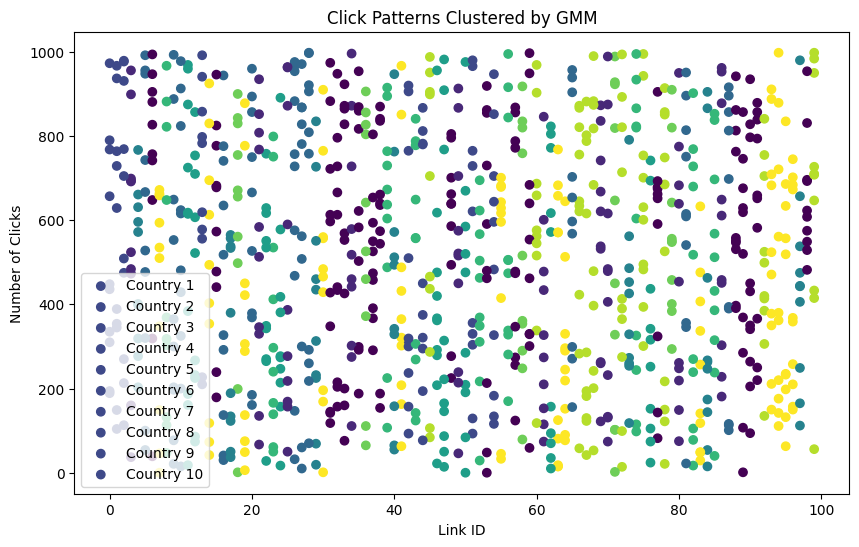

In [ ]:
labels = gmm.predict(click_data_normalized)
df['Cluster'] = labels

plt.figure(figsize=(10, 6))
for i in range(10):
    plt.scatter(df.index, click_data.iloc[:, i], c=df['Cluster'], label=f'Country {i+1}')
plt.title('Click Patterns Clustered by GMM')
plt.xlabel('Link ID')
plt.ylabel('Number of Clicks')
plt.legend()
plt.show()